# Construção do dataset com distribuição Dirichlet

## 1. Importar Bibliotecas

In [127]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponível: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU disponível: []


## 2. Carregar Dataset

### 2.1 Distribuição Dirichlet

In [ ]:
# Carregar dataset
with open('dataset/complete_dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

ALPHA = 25
SEED = 43

X = dataset['signals']
y = dataset['labels']
class_names = dataset['class_names']

print(f"Dataset carregado:")
print(f"  Shape dos sinais: {X.shape}")
print(f"  Shape dos labels: {y.shape}")
print(f"  Número de classes: {len(class_names)}")

Dataset carregado:
  Shape dos sinais: (22500, 1536)
  Shape dos labels: (22500,)
  Número de classes: 9


In [129]:
# 1. Separar 15% para teste global (stratificado)
X_temp, data_global_test_X, y_temp, data_global_test_y = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

# Teste global
data_global_test = {
    'X': data_global_test_X,
    'y': data_global_test_y,
    'class_names': class_names
}

# Dados para criar federados
X_filtered = X_temp
y_filtered = y_temp

print(f"\nDivisão inicial:")
print(f"  Dataset para divisão federada: {X_temp.shape} - {X_temp.shape[0]/X.shape[0]*100:.2f}%")
print(f"  Dataset de teste global: {data_global_test_X.shape} - {data_global_test_X.shape[0]/X.shape[0]*100:.2f}%")


Divisão inicial:
  Dataset para divisão federada: (19125, 1536) - 85.00%
  Dataset de teste global: (3375, 1536) - 15.00%


In [ ]:
def create_federated_datasets_dirichlet(X, y, n_clients=5, alpha=50, 
                                                 classes=9, seed=SEED):
    """
    Implementação CORRETA usando Dirichlet - SEM PERDA DE DADOS
    
    Baseado em:
    - NIID-Bench (GitHub oficial)
    - Hsu et al. (2019) - "Measuring Effects of Non-IID"
    - Li et al. (2022) - "Federated Learning on Non-IID Data Silos"
    """
    np.random.seed(seed)
    
    # Índices por classe
    class_indices = {k: np.where(y == k)[0].tolist() for k in range(classes)}
    
    # Inicializar índices dos clientes
    client_indices = [[] for _ in range(n_clients)]
    
    # MÉTODO CORRETO: Para cada classe, distribuir TODAS as amostras entre clientes
    for class_id in range(classes):
        indices = class_indices[class_id]
        n_samples_class = len(indices)
        
        if n_samples_class == 0:
            continue
        
        # Embaralhar índices desta classe
        np.random.shuffle(indices)
        
        # Samplear proporções de clientes usando Dirichlet
        # Isto define quanto cada cliente receberá DESTA classe específica
        proportions = np.random.dirichlet([alpha] * n_clients)
        
        # Converter proporções em contagens
        counts = (proportions * n_samples_class).astype(int)
        
        # Ajustar para garantir que soma = n_samples_class (sem perder dados)
        diff = n_samples_class - counts.sum()
        if diff > 0:
            # Adicionar amostras faltantes aos clientes com maiores proporções
            for i in np.argsort(proportions)[-diff:]:
                counts[i] += 1
        elif diff < 0:
            # Remover amostras extras dos clientes com menores proporções
            for i in np.argsort(proportions)[:abs(diff)]:
                if counts[i] > 0:
                    counts[i] -= 1
        
        # Distribuir índices para os clientes
        start_idx = 0
        for client_id in range(n_clients):
            end_idx = start_idx + counts[client_id]
            client_indices[client_id].extend(indices[start_idx:end_idx])
            start_idx = end_idx
    
    # Verificar se todos os dados foram distribuídos
    total_distributed = sum(len(idx) for idx in client_indices)
    print(f"✅ Total de amostras: {len(y)}")
    print(f"✅ Amostras distribuídas: {total_distributed}")
    assert total_distributed == len(y), f"ERRO: Perda de dados! {total_distributed} != {len(y)}"
    
    # Criar datasets finais
    federated_datasets = {}
    for client_id in range(n_clients):
        indices = np.array(client_indices[client_id])
        
        if len(indices) > 0:
            # Embaralhar índices do cliente
            np.random.shuffle(indices)
            
            federated_datasets[f'data_fed_{client_id+1}'] = {
                'X': X[indices],
                'y': y[indices],
                'client_id': client_id,
                'n_samples': len(indices)
            }
            
            # Mostrar distribuição de classes deste cliente
            unique, counts = np.unique(y[indices], return_counts=True)
            print(f"\n📊 Cliente {client_id+1}:")
            print(f"   Total: {len(indices)} amostras")
            for cls, cnt in zip(unique, counts):
                pct = (cnt/len(indices))*100
                print(f"   Classe {cls}: {cnt} ({pct:.1f}%)")
    
    return federated_datasets

In [131]:
# 4. Função para analisar estatísticas dos datasets federados
def analyze_federated_datasets(fed_datasets, alpha_value=None):
    """
    Analisa e imprime estatísticas dos datasets federados
    """
    if alpha_value is not None:
        print(f"\n" + "="*60)
        print(f"ANÁLISE - α = {alpha_value}")
        print("="*60)
    else:
        print("\n" + "="*60)
        print("ANÁLISE DOS DATASETS FEDERADOS")
        print("="*60)
    
    total_stats = {
        'total_samples': 0,
        'per_client_samples': [],
        'class_distribution': np.zeros(9),
        'class_presence': np.zeros(9)  # Em quantos clientes cada classe aparece
    }
    
    for client_name, data in fed_datasets.items():
        X_client = data['X']
        y_client = data['y']
        
        total_stats['total_samples'] += len(y_client)
        total_stats['per_client_samples'].append(len(y_client))
        
        # Distribuição por classe
        unique, counts = np.unique(y_client, return_counts=True)
        for label, count in zip(unique, counts):
            total_stats['class_distribution'][label] += count
            total_stats['class_presence'][label] += 1
        
        # Imprimir estatísticas do cliente
        print(f"\n{client_name}:")
        print(f"  Total amostras: {len(y_client)}")
        print(f"  Distribuição por classe:")
        
        # Ordenar por label para facilitar leitura
        for label in range(9):
            if label in unique:
                idx = np.where(unique == label)[0][0]
                count = counts[idx]
                percentage = count/len(y_client)*100
                print(f"    Label {label}: {count:4d} ({percentage:5.1f}%)")
    
    # Estatísticas globais
    print("\n" + "-"*60)
    print("ESTATÍSTICAS GLOBAIS:")
    print(f"Total de amostras distribuídas: {total_stats['total_samples']}")
    if len(total_stats['per_client_samples']) > 0:
        print(f"Média de amostras por cliente: {np.mean(total_stats['per_client_samples']):.1f} ± {np.std(total_stats['per_client_samples']):.1f}")
        print(f"Mínimo de amostras por cliente: {np.min(total_stats['per_client_samples'])}")
        print(f"Máximo de amostras por cliente: {np.max(total_stats['per_client_samples'])}")
    
    print("\nDistribuição total por classe:")
    for label in range(9):
        count = total_stats['class_distribution'][label]
        if total_stats['total_samples'] > 0:
            percentage = count/total_stats['total_samples']*100
            presence = total_stats['class_presence'][label]
            print(f"  Label {label}: {count:6f} amostras ({percentage:5.1f}%) - presente em {presence}/6 clientes")
    
    # Calcular não-IID-ness (medida comum na literatura)
    print("\nMEDIDA DE NÃO-IID (Desvio padrão das proporções por classe):")
    class_proportions = []
    for client_name, data in fed_datasets.items():
        y_client = data['y']
        unique, counts = np.unique(y_client, return_counts=True)
        proportions = np.zeros(9)
        for label, count in zip(unique, counts):
            proportions[label] = count/len(y_client)
        class_proportions.append(proportions)
    
    if class_proportions:
        class_proportions = np.array(class_proportions)
        for label in range(9):
            std = np.std(class_proportions[:, label])
            mean = np.mean(class_proportions[:, label])
            if mean > 0:
                cv = std/mean  # Coeficiente de variação
                print(f"  Label {label}: média={mean:.3f}, std={std:.3f}, CV={cv:.3f}")

In [ ]:
# 5. Criar datasets com diferentes níveis de não-IID (padrão na literatura)
print("\n" + "="*60)
print("CRIANDO DATASETS FEDERADOS - ABORDAGEM DA LITERATURA")
print("="*60)

print("\n" + "="*60)
print(f"\nα = {ALPHA}:")
fed_datasets_alpha = create_federated_datasets_dirichlet(
    X_filtered, y_filtered, 
    n_clients=5, 
    alpha=ALPHA,
    classes=9,
    seed=SEED
)
analyze_federated_datasets(fed_datasets_alpha, alpha_value=ALPHA)


CRIANDO DATASETS FEDERADOS - ABORDAGEM DA LITERATURA


α = 25:
✅ Total de amostras: 19125
✅ Amostras distribuídas: 19125

📊 Cliente 1:
   Total: 3937 amostras
   Classe 0: 466 (11.8%)
   Classe 1: 288 (7.3%)
   Classe 2: 441 (11.2%)
   Classe 3: 446 (11.3%)
   Classe 4: 369 (9.4%)
   Classe 5: 481 (12.2%)
   Classe 6: 535 (13.6%)
   Classe 7: 436 (11.1%)
   Classe 8: 475 (12.1%)

📊 Cliente 2:
   Total: 3771 amostras
   Classe 0: 416 (11.0%)
   Classe 1: 403 (10.7%)
   Classe 2: 343 (9.1%)
   Classe 3: 521 (13.8%)
   Classe 4: 431 (11.4%)
   Classe 5: 424 (11.2%)
   Classe 6: 380 (10.1%)
   Classe 7: 334 (8.9%)
   Classe 8: 519 (13.8%)

📊 Cliente 3:
   Total: 3887 amostras
   Classe 0: 419 (10.8%)
   Classe 1: 558 (14.4%)
   Classe 2: 461 (11.9%)
   Classe 3: 375 (9.6%)
   Classe 4: 399 (10.3%)
   Classe 5: 383 (9.9%)
   Classe 6: 457 (11.8%)
   Classe 7: 463 (11.9%)
   Classe 8: 372 (9.6%)

📊 Cliente 4:
   Total: 3822 amostras
   Classe 0: 321 (8.4%)
   Classe 1: 426 (11.1%)
   Classe

In [133]:
# 8. Salvar todos os datasets para experimentos
print("\n" + "="*60)
print("SALVANDO DATASETS PARA EXPERIMENTOS")
print("="*60)

# Salvar diferentes níveis de não-IID
all_datasets = {
    'data_global_test': data_global_test,
    f'fed_datasets_alpha_{ALPHA}': fed_datasets_alpha,
    'metadata': {
        'original_shape': X.shape,
        'filtered_shape': X_filtered.shape,
        'test_size': len(data_global_test_y),
        'n_clients': 5,
        'classes_used': list(range(9)),
        'class_names': class_names[:9],
        'alpha_values': {
            'alpha': ALPHA,
        }
    }
}

with open(f'dataset/federated_datasets_dirichlet_{ALPHA}.pkl', 'wb') as f:
    pickle.dump(all_datasets, f)

print(f"Datasets salvos em 'dataset/federated_datasets_dirichlet_{ALPHA}.pkl'")
print("\nConteúdo salvo:")
print("- Dataset de teste global (15% dos dados originais)")


SALVANDO DATASETS PARA EXPERIMENTOS
Datasets salvos em 'dataset/federated_datasets_dirichlet_25.pkl'

Conteúdo salvo:
- Dataset de teste global (15% dos dados originais)


### 2.2 Visualizando dados

In [134]:
# ============================
# 1. CARREGAR E PREPARAR DADOS
# ============================
print(f"Carregando datasets federados (α={ALPHA})...")
with open(f'dataset/federated_datasets_dirichlet_{ALPHA}.pkl', 'rb') as f:
    data = pickle.load(f)

fed_datasets = data[f'fed_datasets_alpha_{ALPHA}']
alpha_label = ALPHA

class_names = data['metadata']['class_names']

# Preparar dados
clients = sorted(fed_datasets.keys())
n_clients = len(clients)
n_classes = len(class_names)

# Matriz de distribuição
dist_matrix = np.zeros((n_clients, n_classes))
for i, client_name in enumerate(clients):
    y_client = fed_datasets[client_name]['y']
    for label in range(n_classes):
        dist_matrix[i, label] = np.sum(y_client == label)

# Converter para porcentagem
sample_counts = np.sum(dist_matrix, axis=1)
dist_perc = dist_matrix / sample_counts[:, np.newaxis] * 100

print(f"\nDados preparados:")
print(f"- Clientes: {n_clients}")
print(f"- Classes: {n_classes}")
print(f"- α = {alpha_label}")
print(f"- Total amostras federadas: {int(np.sum(dist_matrix))}")

Carregando datasets federados (α=25)...

Dados preparados:
- Clientes: 5
- Classes: 9
- α = 25
- Total amostras federadas: 19125


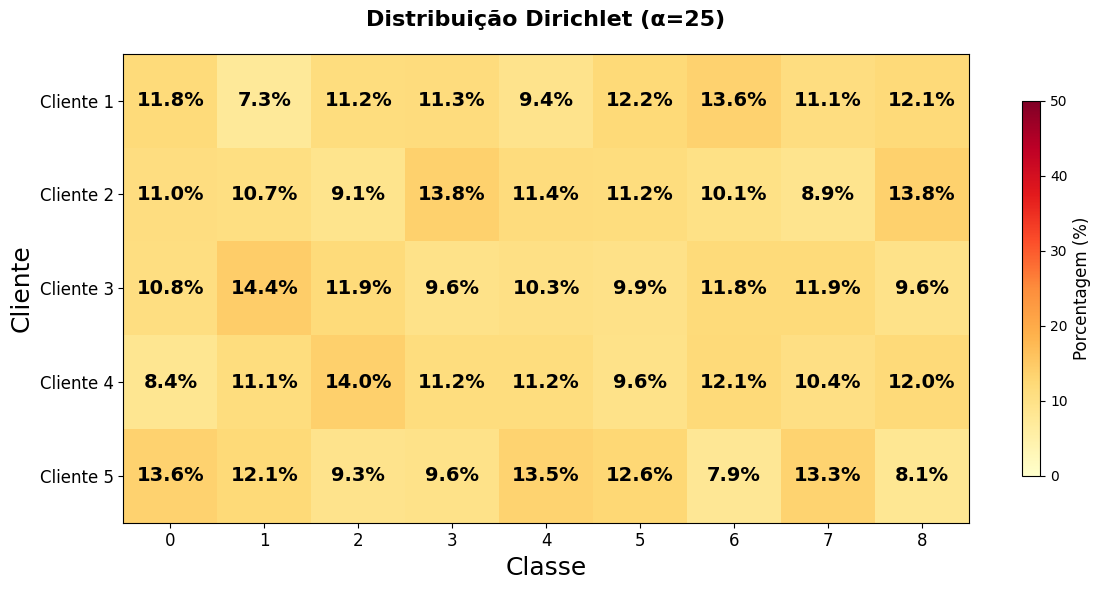

In [135]:
# ============================
# 2. VISUALIZAÇÃO 1: HEATMAP
# ============================
plt.figure(figsize=(12, 6))
im = plt.imshow(dist_perc, aspect='auto', cmap='YlOrRd', vmin=0, vmax=50)

plt.title(f'Distribuição Dirichlet (α={alpha_label})', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Classe', fontsize=18)
plt.ylabel('Cliente', fontsize=18)

# Configurar ticks
plt.xticks(range(n_classes), [f'{i}' for i in range(n_classes)], fontsize=12)
plt.yticks(range(n_clients), [f'Cliente {i+1}' for i in range(n_clients)], fontsize=12)

# Adicionar valores
for i in range(n_clients):
    for j in range(n_classes):
        if dist_perc[i, j] > 1:  # Mostrar valores > 4%
            plt.text(j, i, f'{dist_perc[i, j]:.1f}%',
                    ha="center", va="center", 
                    color="white" if dist_perc[i, j] > 25 else "black",
                    fontsize=14, fontweight='bold')

cbar = plt.colorbar(im, shrink=0.8)
cbar.set_label('Porcentagem (%)', fontsize=12)

plt.tight_layout()
plt.savefig(f'dirichlet/heatmap_alpha_{alpha_label}.png', dpi=300, bbox_inches='tight')
plt.show()

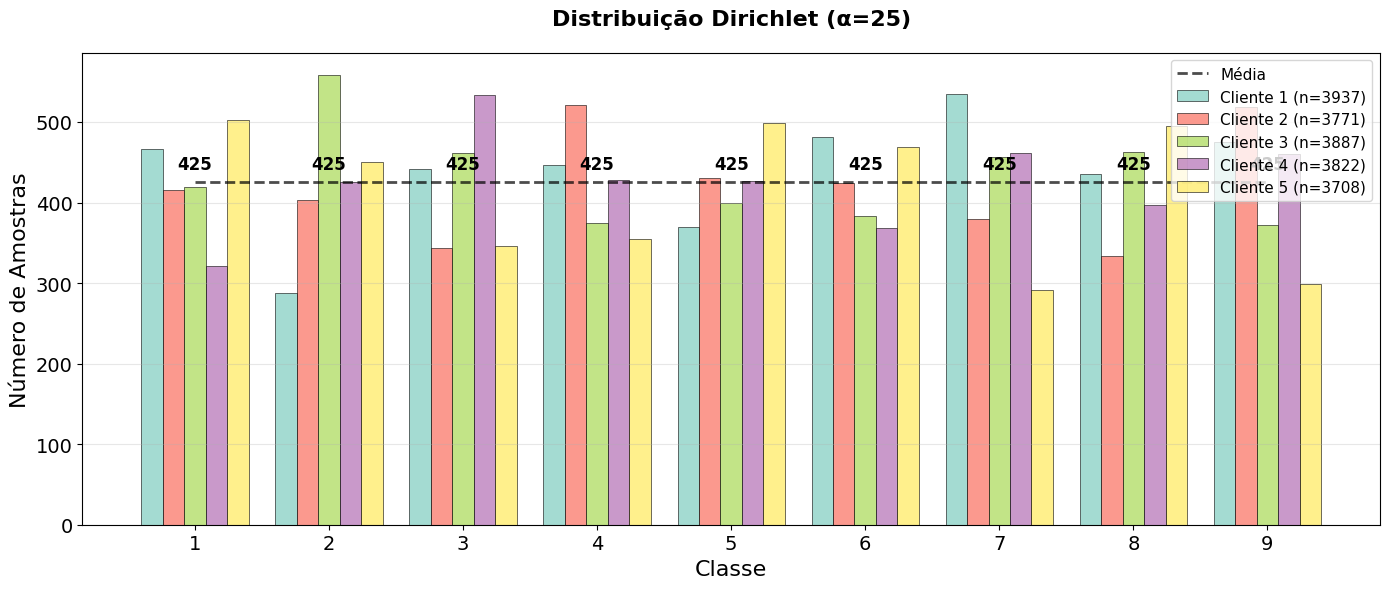

In [136]:
# ============================
# 3. VISUALIZAÇÃO 2: BARRAS AGRUPADAS
# ============================
plt.figure(figsize=(14, 6))

# Eixo X agora vai de 1 até n_classes
x = np.arange(1, n_classes + 1)
width = 0.8 / n_clients

# Cores diferentes para cada cliente
colors = plt.cm.Set3(np.linspace(0, 1, n_clients))

for i in range(n_clients):
    offset = (i - n_clients/2 + 0.5) * width
    plt.bar(x + offset, dist_matrix[i], width, 
            color=colors[i], 
            label=f'Cliente {i+1} (n={int(sample_counts[i])})',
            alpha=0.8, edgecolor='black', linewidth=0.5)

plt.title(f'Distribuição Dirichlet (α={alpha_label})', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Classe', fontsize=16)
plt.ylabel('Número de Amostras', fontsize=16)

# Atualização dos valores no eixo X para 1 a n_classes
plt.xticks(x, [str(i) for i in x], fontsize=14)

plt.yticks(fontsize=14)
plt.grid(True, alpha=0.3, axis='y')

# Legenda
plt.legend(fontsize=14, ncol=2, loc='upper right', framealpha=0.9)

# Adicionar linha da média
mean_by_class = np.mean(dist_matrix, axis=0)
plt.plot(x, mean_by_class, 'k--', linewidth=2, label='Média', alpha=0.7)

for j, mean_val in enumerate(mean_by_class):
    plt.text(x[j], mean_val + np.max(dist_matrix)/50, 
             f'{mean_val:.0f}', ha='center', va='bottom',
             fontsize=12, fontweight='bold')

#plt.ylim(250, 610)
plt.legend(fontsize=11, loc='upper right')

plt.tight_layout()
plt.savefig(f'dirichlet/barras_alpha_{alpha_label}.png', dpi=300, bbox_inches='tight')
plt.show()


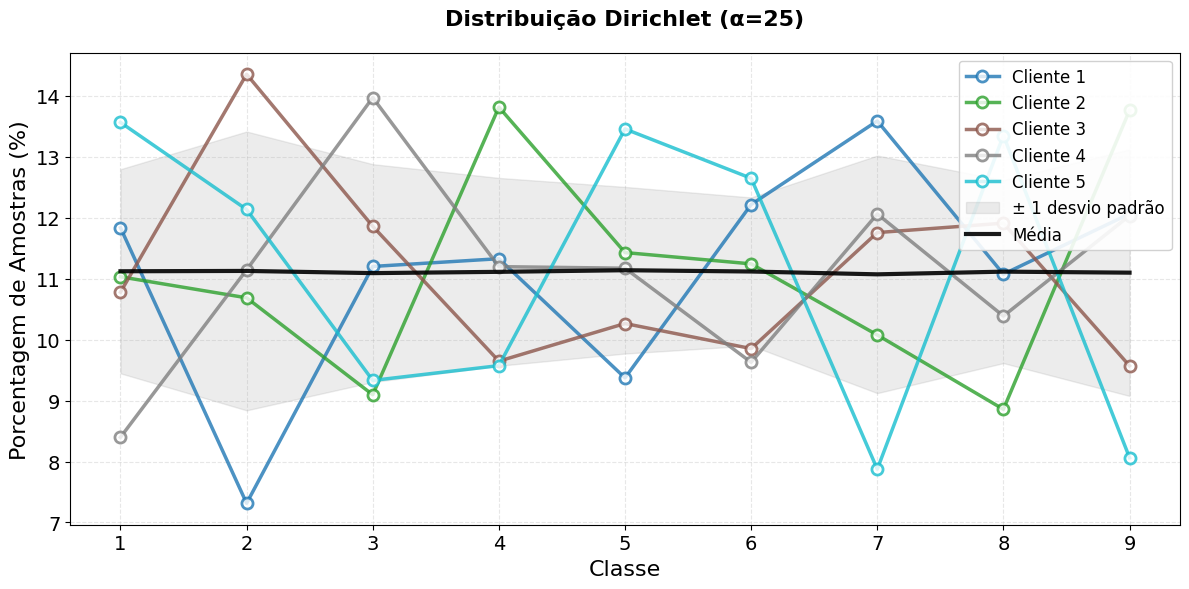

In [137]:
# ============================
# 4. VISUALIZAÇÃO 3: HETEROGENEIDADE
# ============================
plt.figure(figsize=(12, 6))

# Cores para as linhas dos clientes
line_colors = plt.cm.tab10(np.linspace(0, 1, n_clients))

# Novo eixo X indo de 1 a n_classes
x_vals = np.arange(1, n_classes + 1)

# Plotar cada cliente
for i in range(n_clients):
    plt.plot(x_vals, dist_perc[i], 'o-', 
             color=line_colors[i], 
             linewidth=2.5, 
             markersize=8,
             markerfacecolor='white',
             markeredgecolor=line_colors[i],
             markeredgewidth=2,
             label=f'Cliente {i+1}',
             alpha=0.8)

# Média e desvio padrão
mean_perc = np.mean(dist_perc, axis=0)
std_perc = np.std(dist_perc, axis=0)

plt.fill_between(x_vals, 
                 mean_perc - std_perc, 
                 mean_perc + std_perc, 
                 alpha=0.15, color='gray', 
                 label='± 1 desvio padrão')

plt.plot(x_vals, mean_perc, 'k-', linewidth=3, 
         label='Média', alpha=0.9)

plt.title(f'Distribuição Dirichlet (α={alpha_label})', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Classe', fontsize=16)
plt.ylabel('Porcentagem de Amostras (%)', fontsize=16)

# Ajuste dos rótulos do eixo X (1 a n_classes)
plt.xticks(x_vals, [str(i) for i in x_vals], fontsize=14)

plt.yticks(fontsize=14)
plt.grid(True, alpha=0.3, linestyle='--')

# Configurar limites do eixo Y
#plt.ylim(7, max(np.max(dist_perc) * 1.1, 15))

# Legenda
plt.legend(fontsize=12, loc='upper right', framealpha=0.9)

plt.tight_layout()
plt.savefig(f'dirichlet/heterogeneidade_alpha_{alpha_label}.png', dpi=300, bbox_inches='tight')
plt.show()


In [138]:
# ========================================
# 5. GERAÇÃO DO RELATÓRIO (COM CAPTURA)
# ========================================

import io
import sys
from contextlib import redirect_stdout


# Buffer para capturar tudo o que for impresso
report_buffer = io.StringIO()

# Redireciona prints para o buffer e também para o console
class DualWriter:
    def __init__(self, *writers):
        self.writers = writers
    def write(self, text):
        for w in self.writers:
            w.write(text)
    def flush(self):
        for w in self.writers:
            w.flush()

dual_output = DualWriter(sys.stdout, report_buffer)

with redirect_stdout(dual_output):

    print("\n" + "="*60)
    print(f"ANÁLISE ESTATÍSTICA - α = {alpha_label}")
    print("="*60)

    print(f"\nRESUMO POR CLIENTE:")
    print("-" * 50)
    print(f"{'Cliente':<10} {'Amostras':<10} {'Média/Classe':<15} {'Std':<10} {'Min':<10} {'Max':<10}")
    print("-" * 80)

    for i in range(n_clients):
        stats = {
            'total': int(sample_counts[i]),
            'mean': np.mean(dist_perc[i]),
            'std': np.std(dist_perc[i]),
            'min': np.min(dist_perc[i]),
            'max': np.max(dist_perc[i])
        }
        
        print(f"{f'Cliente {i+1}':<10} {stats['total']:<10} {stats['mean']:<15.1f} "
            f"{stats['std']:<10.1f} {stats['min']:<10.1f} {stats['max']:<10.1f}")

    print(f"\nHETEROGENEIDADE POR CLASSE:")
    print("-" * 50)
    print(f"{'Classe':<8} {'Média (%)':<12} {'Std (%)':<12} {'CV (%)':<12} {'Min-Max (%)':<20}")
    print("-" * 80)

    for j in range(n_classes):
        class_data = dist_perc[:, j]
        mean_val = np.mean(class_data)
        std_val = np.std(class_data)
        cv_val = (std_val / mean_val * 100) if mean_val > 0 else 0
        min_max = f"{np.min(class_data):.1f}-{np.max(class_data):.1f}"
        
        print(f"{j:<8} {mean_val:<12.1f} {std_val:<12.1f} {cv_val:<12.1f} {min_max:<20}")

    # --- Medidas globais ---
    print(f"\nMEDIDAS GLOBAIS DE HETEROGENEIDADE:")
    print("-" * 40)

    cv_values = []
    for j in range(n_classes):
        if np.mean(dist_perc[:, j]) > 0:
            cv = np.std(dist_perc[:, j]) / np.mean(dist_perc[:, j])
            cv_values.append(cv)

    mean_cv = np.mean(cv_values) * 100
    print(f"Coeficiente de Variação Médio: {mean_cv:.1f}%")

    max_diffs = []
    for j in range(n_classes):
        max_diff = np.max(dist_perc[:, j]) - np.min(dist_perc[:, j])
        max_diffs.append(max_diff)

    mean_max_diff = np.mean(max_diffs)
    print(f"Diferença Máxima Média: {mean_max_diff:.1f} pontos percentuais")

    std_by_class = np.std(dist_perc, axis=0)
    most_hetero = np.argmax(std_by_class)
    least_hetero = np.argmin(std_by_class)

    print(f"\nClasse MAIS heterogênea: {most_hetero}")
    print(f"  Varia de {np.min(dist_perc[:, most_hetero]):.1f}% a {np.max(dist_perc[:, most_hetero]):.1f}%")
    print(f"  Desvio padrão: {std_by_class[most_hetero]:.1f}%")

    print(f"\nClasse MENOS heterogênea: {least_hetero}")
    print(f"  Varia de {np.min(dist_perc[:, least_hetero]):.1f}% a {np.max(dist_perc[:, least_hetero]):.1f}%")
    print(f"  Desvio padrão: {std_by_class[least_hetero]:.1f}%")

    balance_ratio = np.min(sample_counts) / np.max(sample_counts)
    print(f"\nBalanceamento de tamanho entre clientes: {balance_ratio:.2f}")
    print(f"  Maior cliente: {int(np.max(sample_counts))} amostras")
    print(f"  Menor cliente: {int(np.min(sample_counts))} amostras")
    print(f"  Diferença: {int(np.max(sample_counts) - np.min(sample_counts))} amostras")

    print(f"\n" + "="*60)
    print("GRÁFICOS SALVOS:")
    print("="*60)
    print(f"1. heatmap_alpha_{alpha_label}.png")
    print(f"2. barras_alpha_{alpha_label}.png")
    print(f"3. heterogeneidade_alpha_{alpha_label}.png")
    print(f"\nAnálise concluída para α = {alpha_label}!")



ANÁLISE ESTATÍSTICA - α = 25

RESUMO POR CLIENTE:
--------------------------------------------------
Cliente    Amostras   Média/Classe    Std        Min        Max       
--------------------------------------------------------------------------------
Cliente 1  3937       11.1            1.7        7.3        13.6      
Cliente 2  3771       11.1            1.7        8.9        13.8      
Cliente 3  3887       11.1            1.5        9.6        14.4      
Cliente 4  3822       11.1            1.5        8.4        14.0      
Cliente 5  3708       11.1            2.2        7.9        13.6      

HETEROGENEIDADE POR CLASSE:
--------------------------------------------------
Classe   Média (%)    Std (%)      CV (%)       Min-Max (%)         
--------------------------------------------------------------------------------
0        11.1         1.7          15.1         8.4-13.6            
1        11.1         2.3          20.6         7.3-14.4            
2        11.1         1

In [139]:
# ========================================
# 6. SALVAR ARQUIVO TXT
# ========================================

relatorio_txt = report_buffer.getvalue()
output_path = f"dirichlet/relatorio_alpha_{alpha_label}.txt"

with open(output_path, "w", encoding="utf-8") as f:
    f.write(relatorio_txt)

print(f"\nRelatório salvo em: {output_path}")



Relatório salvo em: dirichlet/relatorio_alpha_25.txt
